In [52]:
import yfinance as yf

# Fetch historical data for a stock
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Fetch up to the current date (today)
stock_data = get_stock_data("AAPL", "2000-01-01", "2024-12-01")

# stock_data = get_stock_data("AAPL", "2000-01-01", "2023-01-01")


[*********************100%***********************]  1 of 1 completed


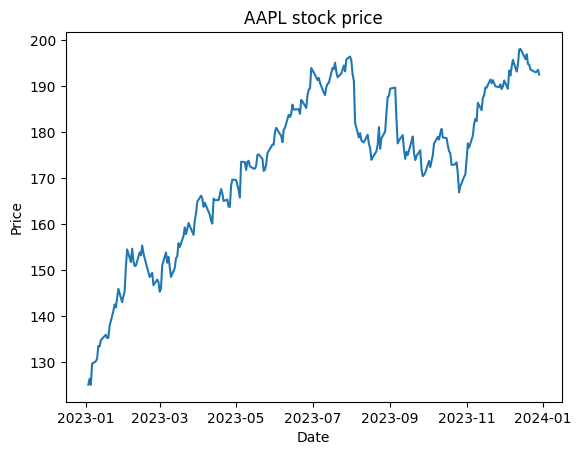

In [53]:
# Plot the stock during from 2011 to 2021

import matplotlib.pyplot as plt

# Plot the stock during from 2011-1-1 to 2021-1-1
plt.plot(stock_data['Close'].loc['2023-01-01':'2023-12-31'])
# plt.plot(stock_data['Close'].loc['2011-01-01':'2023-12-01'])
plt.title('AAPL stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# plt.plot(stock_data['Close'])
# plt.title('AAPL stock price')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()

In [25]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Extract 'Close' prices and scale them
prices = stock_data['Close'].values
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 60  # Use past 60 days to predict the next day
X, y = create_sequences(prices_scaled, sequence_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the data into training and test sets randomly 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step
        return out

# Define hyperparameters
input_size = 1  # One feature: the scaled closing price
hidden_size = 50
num_layers = 2
output_size = 1

model = StockLSTM(input_size, hidden_size, num_layers, output_size)


In [29]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device ='mps'
model.to(device)

# Train the model
epochs = 10
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(X_train) - batch_size, batch_size):
        model.train()
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluate the model every 10 steps
    if (epoch+1) % 10 == 0:
        model.eval()
        for i in range(0, len(X_test) - batch_size, batch_size):
            X_batch = X_test[i:i + batch_size]
            y_batch = y_test[i:i + batch_size]
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                test_outputs = model(X_batch)
                test_loss = criterion(test_outputs, y_batch)
                            
        print(f"Epoch {epoch+1}/{epochs}, Step {i+1}, Loss: {loss.item()}, Test Loss: {test_loss.item()}")
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


Epoch 1/10, Loss: 0.00016566630802117288
Epoch 2/10, Loss: 0.00013407408550847322
Epoch 3/10, Loss: 0.0001144265552284196
Epoch 4/10, Loss: 0.00010509575804462656
Epoch 5/10, Loss: 0.00011455793719505891
Epoch 6/10, Loss: 0.00014632560487370938
Epoch 7/10, Loss: 0.000163232849445194
Epoch 8/10, Loss: 0.0001650852500461042
Epoch 9/10, Loss: 0.00016055670857895166
Epoch 10/10, Step 1089, Loss: 0.00015335759962908924, Test Loss: 0.00018406298477202654
Epoch 10/10, Loss: 0.00015335759962908924


In [30]:
model.eval()
model.to('cpu')
with torch.no_grad():
    test_inputs = X[-batch_size:]
    predictions = model(test_inputs).numpy()

# Reverse scaling
predictions_unscaled = scaler.inverse_transform(predictions)


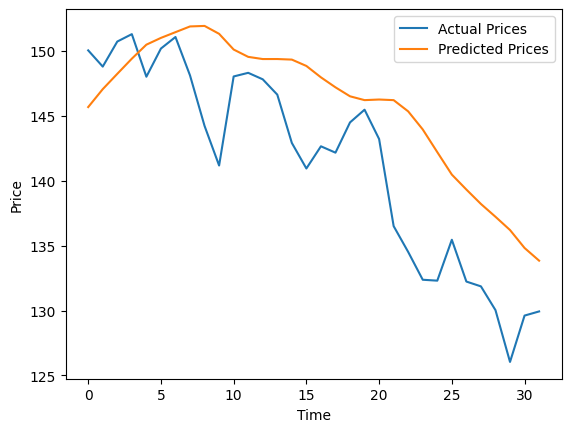

In [31]:
# plot the predicted and actual stock prices

import matplotlib.pyplot as plt

actual_prices = stock_data['Close'].values[-batch_size:]
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predictions_unscaled, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

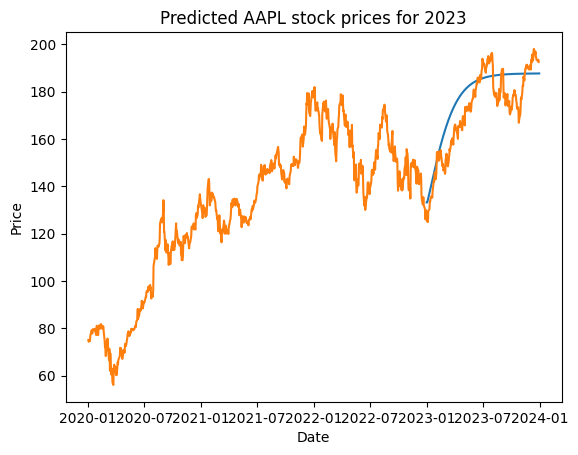

In [55]:
# Predict Stock prices from 2023-01-01 to 2023-12-31 and plot the results
import pandas as pd
import datetime

start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 12, 31)
future_dates = pd.date_range(start_date, end_date)

# Use the last available data to predict future prices
last_sequence = prices_scaled[-sequence_length:]
future_predictions = []

model.eval()
model.to('mps')
with torch.no_grad():
    for _ in range(len(future_dates)):
        X_future = torch.tensor(last_sequence.reshape(1, sequence_length, 1), dtype=torch.float32).to(device)
        prediction = model(X_future).cpu().numpy()
        future_predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction)

# Reverse scaling
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the predicted stock prices for 2023
plt.plot(future_dates, future_predictions_unscaled)
# plot the actual stock prices as well between 2023-01-01 and 2023-12-31
plt.plot(stock_data['Close'].loc['2020-01-01':'2023-12-31'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted AAPL stock prices for 2023')
plt.show()

In [56]:
future_predictions_unscaled

array([[133.20279],
       [133.19435],
       [133.49548],
       [133.95665],
       [134.49786],
       [135.0769 ],
       [135.67212],
       [136.27296],
       [136.87454],
       [137.47488],
       [138.07327],
       [138.66963],
       [139.26398],
       [139.85643],
       [140.44704],
       [141.03584],
       [141.6228 ],
       [142.20782],
       [142.79086],
       [143.3718 ],
       [143.95052],
       [144.52693],
       [145.10085],
       [145.67221],
       [146.24089],
       [146.80676],
       [147.36967],
       [147.92958],
       [148.48633],
       [149.03981],
       [149.58989],
       [150.13652],
       [150.67958],
       [151.21895],
       [151.75455],
       [152.28627],
       [152.81401],
       [153.33772],
       [153.85728],
       [154.37263],
       [154.8837 ],
       [155.39038],
       [155.89262],
       [156.39037],
       [156.8835 ],
       [157.37202],
       [157.85585],
       [158.33495],
       [158.80922],
       [159.27866],
